In [1]:
# # Path to h5ad dataset
# dataset_path = '/work/vanaja_lab/griffin/projects/cshmm/results/pancreas_dev.h5ad'

# # Load and prepare AnnData
# if os.path.exists(dataset_path):
#     print("File exists. Loading the dataset...")
#     adata = sc.read_h5ad(dataset_path)
#     print("Dataset loaded successfully!")
#     print("Dataset shape:", adata.shape)
# else:
#     raise FileNotFoundError(f"File not found at: {dataset_path}")

# adata.obs_names_make_unique()

# # Preprocessing steps
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # Min-max scaling
# scaler = MinMaxScaler()
# adata.X = scaler.fit_transform(adata.X.toarray())

# # HVG selection
# sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')
# adata = adata[:, adata.var['highly_variable']].copy()

# print(f"Dataset shape after selecting top 1000 HVGs: {adata.shape}")


In [2]:
# Dimensionality reduction and clustering
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=2, key_added="leiden")

# # Plot UMAP with clusters
# sc.pl.umap(adata, color="leiden", legend_loc="on data", title="UMAP - Leiden Clusters")

# # PAGA
# sc.tl.paga(adata, groups='leiden')
# sc.pl.paga(adata, color='leiden', title="PAGA Connectivity Graph")
# sc.pl.umap(adata, color=['leiden'], edges=True, title="UMAP with PAGA Connectivity")


In [3]:
#adata.write('data/mouse_panc_dev.h5ad')

In [4]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

In [5]:
adata = sc.read('data/mouse_panc_dev.h5ad')

In [6]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=41,
    debug=True
)


Trajectory graph nodes: ['leaf_0', 'split_1', 'leaf_2', 'split_3', 'leaf_4', 'split_5', 'leaf_6', 'split_7', 'split_8', 'leaf_9', 'split_10', 'leaf_11', 'int_12', 'leaf_13', 'leaf_14', 'split_15', 'leaf_16', 'root_split_17', 'RootNode_0_0']
Trajectory graph edges: [('split_1', 'leaf_13'), ('split_1', 'leaf_14'), ('split_3', 'split_7'), ('split_3', 'split_8'), ('split_5', 'int_12'), ('split_5', 'leaf_16'), ('split_7', 'leaf_2'), ('split_7', 'leaf_6'), ('split_8', 'leaf_0'), ('split_8', 'leaf_9'), ('split_10', 'split_5'), ('split_10', 'split_15'), ('int_12', 'leaf_11'), ('split_15', 'split_1'), ('split_15', 'leaf_4'), ('root_split_17', 'split_3'), ('root_split_17', 'split_10'), ('RootNode_0_0', 'root_split_17')]

Sample cell assignments:
                                 edge  latent_time
TAAGCGTAGGCCCGTT  (split_15, leaf_4)     0.773956
GACCAATAGTCGTCGT  (split_3, split_8)     0.438878
CGAGAAGCATGCTAGT  (split_15, leaf_4)     0.858598
ACGATGTAGGATTCCC  (split_15, leaf_4)     0.697368
GCA

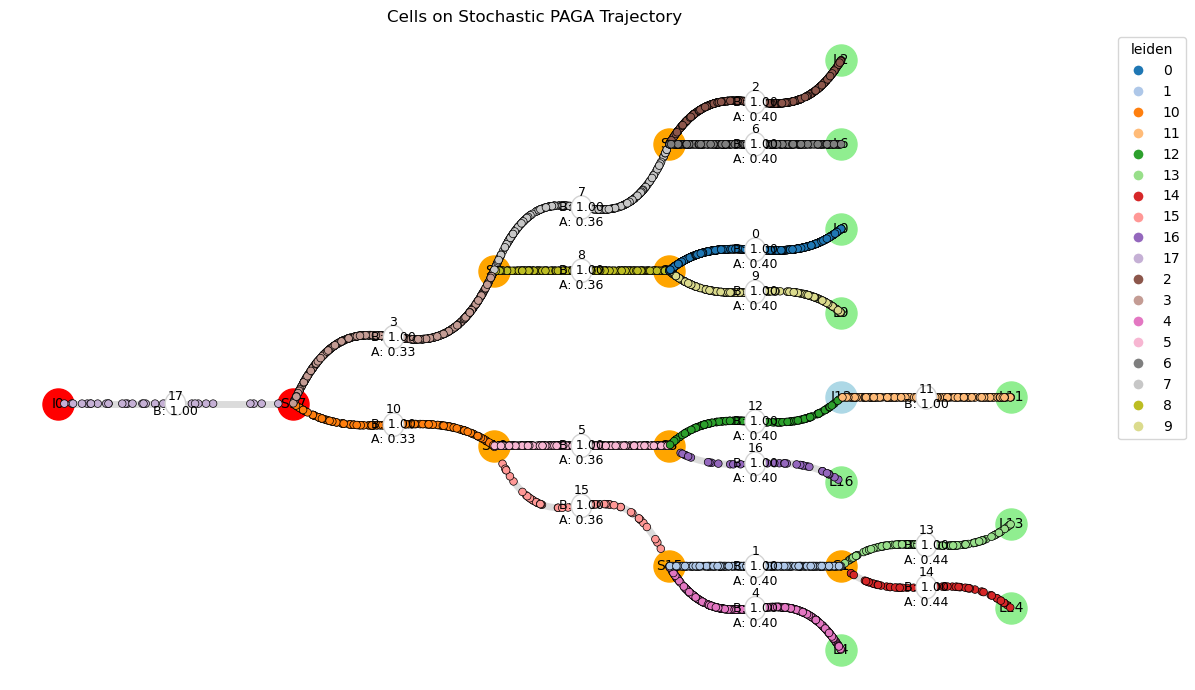

In [7]:
# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='leiden',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


In [8]:
# # === Imports ===

import torch
import numpy as np
from models.posterior import TreeVariationalPosterior
from models.belief import BeliefPropagator
from models.emission import pack_emission_params
from models.loss import compute_elbo
from utils.inference import initialize_beta_from_cell_assignment, find_path_index_for_edge

# # === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Prepare expression data
X = torch.tensor(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    dtype=torch.float32
).to(device)

# Initialize emission parameters
edge_to_index, g_a, g_b, K, sigma2, pi = pack_emission_params(traj_graph, device=device)
g_a = g_a.requires_grad_()
g_b = g_b.requires_grad_()
K = K.requires_grad_()
log_sigma2 = torch.log(sigma2).requires_grad_()

# Posterior
n_cells = X.shape[0]
posterior = TreeVariationalPosterior(traj_graph, n_cells=n_cells, device=device)
posterior.path_logits = torch.nn.Parameter(torch.randn(n_cells, posterior.n_paths, device=device))

# Beta init
initialize_beta_from_cell_assignment(posterior, cell_assignment, sharpness=0.01)

# Belief propagation
belief_propagator = BeliefPropagator(traj_graph, posterior)

# Optimizer
params = [posterior.alpha, posterior.beta, posterior.path_logits, g_a, g_b, K, log_sigma2]
optimizer = torch.optim.Adam(params, lr=1e-2)

# Training config
num_epochs = 10
n_samples = 10
kl_weight = 1.0
kl_p_weight = 1.0
t_cont_weight = 1.0

# === Logging ===
def print_grad_stats():
    grad_alpha = posterior.alpha.grad.abs().mean().item()
    grad_beta = posterior.beta.grad.abs().mean().item()
    print(f"Gradients: α={grad_alpha:.3e}, β={grad_beta:.3e}")

def log_epoch(epoch, loss, metrics):
    print(f"[Epoch {epoch}] Loss: {loss.item():.3e}")
    print(f"  NLL:      {metrics['nll']:.3e}")
    print(f"  KL(t):    {metrics['kl_t']:.3f}")
    print(f"  KL(p):    {metrics['kl_p']:.3f}")
    print(f"  t_cont:   {metrics['t_cont']:.3f}")
    entropy = -(metrics['q_eff'] * metrics['q_eff'].clamp(min=1e-6).log()).sum(dim=1).mean()
    print(f"  Path entropy: {entropy:.3f}")

# Test Standard Full Code

In [10]:
# # === Run Variational Model ===
# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     loss, metrics = compute_elbo(
#         X, traj_graph, posterior, edge_to_index,
#         g_a, g_b, K, log_sigma2.exp(),
#         pi=pi,
#         belief_propagator=belief_propagator,
#         n_samples=n_samples,
#         kl_weight=kl_weight,
#         kl_p_weight=kl_p_weight,
#         t_cont_weight=t_cont_weight
#     )

#     loss.backward()
#     print_grad_stats()
#     log_epoch(epoch, loss, metrics)
#     optimizer.step()


In [11]:
from models.loss import compute_elbo_batch
from utils.inference import batch_indices

batch_size = 512
num_epochs = 5
n_samples = 3

optimizer = torch.optim.Adam(
    [posterior.alpha, posterior.beta, posterior.path_logits, g_a, g_b, K, log_sigma2],
    lr=1e-2
)

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0

    for batch in batch_indices(n_cells, batch_size):
        X_batch = X[batch]
        optimizer.zero_grad()
        
        loss, metrics = compute_elbo_batch(
            X_batch, batch,
            traj_graph, posterior, edge_to_index,
            g_a, g_b, K, log_sigma2.exp(),
            belief_propagator=belief_propagator,
            n_samples=n_samples,
            kl_weight=kl_weight,
            kl_p_weight=kl_p_weight,
            t_cont_weight=t_cont_weight,
            pi=pi
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    print(f"[Epoch {epoch}] Avg Loss: {total_loss / total_batches:.4e}")


[Epoch 0] Avg Loss: 5.7489e+05
[Epoch 1] Avg Loss: 3.7428e+05
[Epoch 2] Avg Loss: 2.4075e+05
[Epoch 3] Avg Loss: 1.5934e+05
[Epoch 4] Avg Loss: 1.1219e+05


In [12]:
# freeze_epochs = 10
# optimizer = torch.optim.Adam([
#     {'params': [posterior.alpha, posterior.beta, posterior.path_logits]},
#     {'params': [g_a, g_b, K, log_sigma2], 'lr': 1e-2}
# ], lr=1e-2)

# for epoch in range(num_epochs):
#     # Freeze emission parameters initially
#     if epoch < freeze_epochs:
#         for p in [g_a, g_b, K, log_sigma2]:
#             p.requires_grad_(False)
#     else:
#         for p in [g_a, g_b, K, log_sigma2]:
#             p.requires_grad_(True)

#     optimizer.zero_grad()
#     loss, metrics = compute_elbo(
#         X, traj_graph, posterior, edge_to_index,
#         g_a, g_b, K, log_sigma2.exp(),
#         pi=pi,
#         belief_propagator=belief_propagator,
#         n_samples=n_samples,
#         kl_weight=kl_weight,
#         kl_p_weight=kl_p_weight,
#         t_cont_weight=t_cont_weight,
#     )
#     loss.backward()
#     optimizer.step()

#     print(f"[Epoch {epoch}] Loss={loss.item():.2e}, NLL={metrics['nll']:.2e}, KL(t)={metrics['kl_t']:.3f}")


In [13]:
# inference_params = [posterior.alpha, posterior.beta, posterior.path_logits]
# generative_params = [g_a, g_b, K, log_sigma2]

# optimizer_inf = torch.optim.Adam(inference_params, lr=1e-2)
# optimizer_gen = torch.optim.Adam(generative_params, lr=1e-2)

# n_inf_steps = 5
# n_gen_steps = 1
# batch_size = 512

# for epoch in range(num_epochs):
#     print(f"\n[Epoch {epoch}]")

#     # === Inference Phase ===
#     for _ in range(n_inf_steps):
#         optimizer_inf.zero_grad()
#         total_elbo = 0
#         for batch in batch_indices(X.shape[0], batch_size):
#             X_batch = X[batch]
#             elbo, _ = compute_elbo_batch(
#                 X_batch, batch,
#                 traj_graph, posterior, edge_to_index,
#                 g_a, g_b, K, log_sigma2.exp(),
#                 belief_propagator=belief_propagator,
#                 n_samples=n_samples,
#                 kl_weight=kl_weight,
#                 kl_p_weight=kl_p_weight,
#                 t_cont_weight=t_cont_weight,
#                 pi=pi
#             )
#             elbo.backward()
#             total_elbo += elbo.item()
#         optimizer_inf.step()
#         print(f"Inference ELBO: {total_elbo:.2e}")

#     # === Generative Phase ===
#     for _ in range(n_gen_steps):
#         optimizer_gen.zero_grad()
#         total_elbo = 0
#         for batch in batch_indices(X.shape[0], batch_size):
#             X_batch = X[batch]
#             elbo, _ = compute_elbo_batch(
#                 X_batch, batch,
#                 traj_graph, posterior, edge_to_index,
#                 g_a, g_b, K, log_sigma2.exp(),
#                 belief_propagator=belief_propagator,
#                 n_samples=n_samples,
#                 kl_weight=kl_weight,
#                 kl_p_weight=kl_p_weight,
#                 t_cont_weight=t_cont_weight,
#                 pi=pi
#             )
#             elbo.backward()
#             total_elbo += elbo.item()
#         optimizer_gen.step()
#         print(f"Generative ELBO: {total_elbo:.2e}")


# Test Plotting

In [14]:
from utils import make_beta_assignment_df

beta_assignments = make_beta_assignment_df(posterior, cell_assignment, sharpness=0.01)


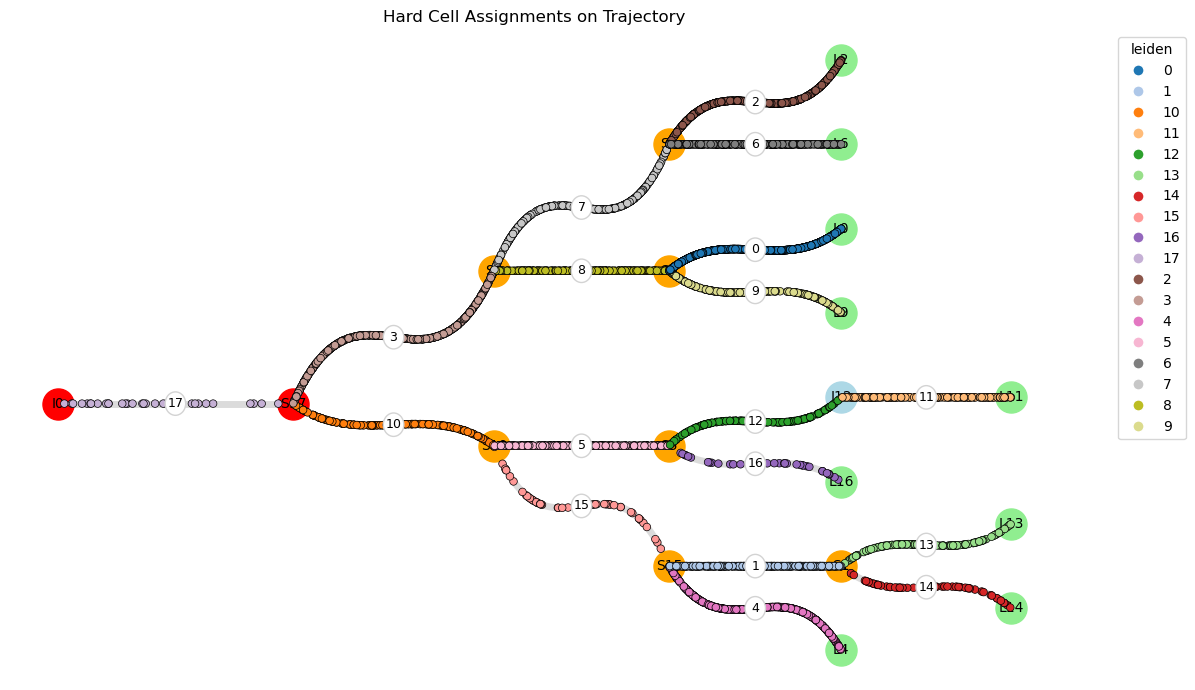

In [15]:
from viz.trajectory import plot_cells_on_trajectory

plot_cells_on_trajectory(
    traj_graph,
    cell_assignment,
    adata,
    color_key="leiden",  # or any other obs key
    curve_amount=0.8,
    title="Hard Cell Assignments on Trajectory"
)


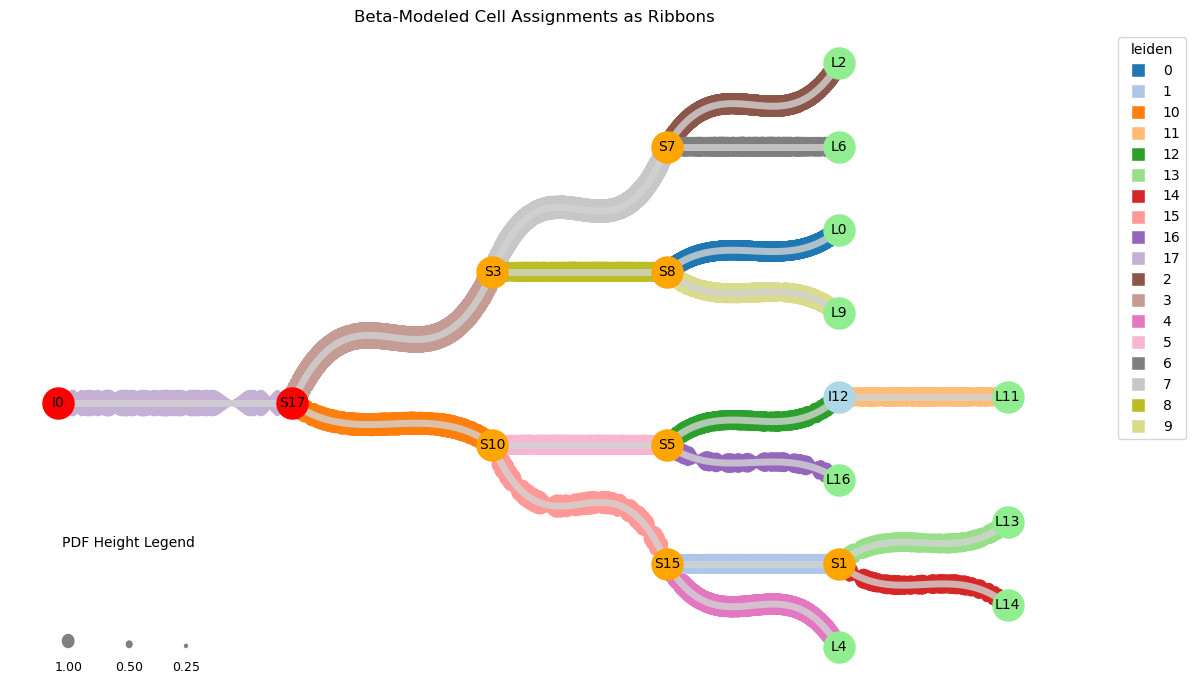

In [16]:
from viz.trajectory import plot_pdf_width_ribbons_on_trajectory

plot_pdf_width_ribbons_on_trajectory(
    traj_graph,
    beta_assignments,
    adata,
    color_key="leiden",
    pdf_scale=0.1,  # adjust if too narrow/wide
    curve_amount=0.8,
    title="Beta-Modeled Cell Assignments as Ribbons"
)


In [36]:
adata.var

,n_cells,highly_variable,means,dispersions,dispersions_norm
Lypla1,2576,True,0.250853,-0.930302,1.950977
Ncoa2,993,True,0.099955,-0.569126,1.877314
Gm10566,76,True,0.010847,-0.106430,1.912057
Imp4,3037,True,0.295466,-1.094584,1.782918
Fam168b,2119,True,0.204745,-0.815239,1.617195
...,...,...,...,...,...
Rps7-ps3,2274,True,0.221367,-0.861823,1.828743
Map3k15,346,True,0.038561,-0.390028,2.149240
Syap1,970,True,0.100843,-0.545244,1.989039
Ctps2,2537,True,0.264015,-0.860618,2.211714


In [50]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd

def plot_gene_dynamics_on_trajectory(
    G_traj, beta_assignments, adata, gene_name,
    resolution=100, curve_scale=1.0, blend_fraction=0.1,
    title="Gene Dynamics with Uncertainty"
):
    """
    Visualizes gene expression dynamics along trajectory edges while incorporating
    uncertainty from cell assignments. The tree structure is drawn first (nodes and
    straight edges). Over each edge, we compute for a set of t-values:
      - A weighted gene expression (which becomes the vertical offset from the base edge)
      - A weighted certainty (a proxy using each cell's beta PDF peak)
    
    The curve is drawn along the edge offset perpendicularly by the weighted expression
    (scaled by curve_scale). If the source node of an edge is a split, the first few points
    of the branch are blended with the parent's endpoint (source node position) using the 
    transition probability (attribute "A") from that edge.
    
    Args:
        G_traj: Trajectory graph (networkx.DiGraph or TrajectoryGraph object).
        beta_assignments (pd.DataFrame): Indexed by cell IDs with columns:
            'edge' (tuple of two node IDs), 'alpha', 'beta'.
        adata: AnnData-like object (for gene expression and cell IDs).
        gene_name (str): Gene to visualize (must be in adata.var_names).
        resolution (int): Number of t-values along each edge.
        curve_scale (float): Factor to scale the vertical offset of the curve.
        blend_fraction (float): Fraction of the curve (from t=0) to blend at split nodes.
        title (str): Plot title.
    """
    # If G_traj is a TrajectoryGraph, extract its underlying networkx graph.
    if hasattr(G_traj, 'G_traj'):
        G_traj = G_traj.G_traj

    # Compute node positions using graphviz layout.
    pos = nx.nx_agraph.graphviz_layout(G_traj, prog="dot", args="-Grankdir=LR")
    plt.figure(figsize=(12, 7))
    
    # Draw the tree structure: nodes and edges.
    for node, (x, y) in pos.items():
        plt.scatter(x, y, color='black', s=500, zorder=3)
        plt.text(x, y, node, fontsize=10, ha="center", va="center", zorder=4)
    for src, dst in G_traj.edges():
        if src not in pos or dst not in pos:
            continue
        P0, P1 = np.array(pos[src]), np.array(pos[dst])
        plt.plot([P0[0], P1[0]], [P0[1], P1[1]], color='lightgrey', lw=5, alpha=0.5, zorder=1)
    
    # Extract gene expression as a pandas Series (indexed by cell IDs).
    if gene_name in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene_name)
        expr_array = (adata.X[:, gene_idx].toarray().ravel() 
                      if hasattr(adata.X, "toarray") 
                      else np.array(adata.X[:, gene_idx]).ravel())
        expr_series = pd.Series(expr_array, index=adata.obs_names)
    else:
        raise ValueError(f"Gene '{gene_name}' not found in adata.var_names")
    
    # Group cells by edge.
    # For each cell, compute its beta PDF along a grid of t-values.
    t_vals = np.linspace(0, 1, resolution)
    edge_groups = {}  # { edge: list of dicts for each cell }
    for cell_id, row in beta_assignments.iterrows():
        edge = row['edge']
        alpha_param = row['alpha']
        beta_param = row['beta']
        if not edge or alpha_param <= 0 or beta_param <= 0:
            continue
        # Compute beta PDF for this cell.
        pdf_vals = beta.pdf(t_vals, alpha_param, beta_param)
        pdf_vals = np.nan_to_num(pdf_vals)
        # Use the maximum of the PDF as a simple measure of certainty.
        cert = pdf_vals.max()
        if edge not in edge_groups:
            edge_groups[edge] = []
        edge_groups[edge].append({
            "cell_id": cell_id,
            "pdf": pdf_vals,
            "expr": expr_series.loc[cell_id],
            "cert": cert
        })
    
    # Prepare a colormap for certainty: blue = low, red = high.
    cmap = cm.RdBu_r

    # For each edge, compute the weighted gene expression and certainty along t.
    for edge, cells in edge_groups.items():
        src, dst = edge
        if src not in pos or dst not in pos:
            continue
        P0 = np.array(pos[src])
        P1 = np.array(pos[dst])
        direction = P1 - P0
        seg_length = np.linalg.norm(direction)
        if seg_length == 0:
            continue
        direction = direction / seg_length
        # Compute a perpendicular (normal) vector.
        normal = np.array([-direction[1], direction[0]])
        
        # Initialize accumulators for weighted expression and certainty.
        weighted_expr = np.zeros_like(t_vals, dtype=float)
        weighted_cert = np.zeros_like(t_vals, dtype=float)
        weight_sum = np.zeros_like(t_vals, dtype=float)
        
        for cell in cells:
            pdf_vals = cell["pdf"]
            weighted_expr += cell["expr"] * pdf_vals
            weighted_cert += cell["cert"] * pdf_vals
            weight_sum += pdf_vals
        
        mask = weight_sum > 0
        weighted_expr[mask] /= weight_sum[mask]
        weighted_cert[mask] /= weight_sum[mask]
        
        # Compute the base curve along the edge.
        base_curve = np.array([P0 + t * (P1 - P0) for t in t_vals])
        # Offset the base curve by the weighted expression along the normal,
        # scaling the offset by curve_scale.
        curve_pts = base_curve + np.outer(weighted_expr * curve_scale, normal)
        
        # If the source node is a split, blend the first few points with the parent's endpoint.
        # We assume that a split node is identified by its type attribute containing "split".
        if "split" in G_traj.nodes[src].get("type", ""):
            # Get the transition probability for this edge (default to 1 if not defined)
            A = G_traj.edges[src, dst].get("A", 1.0)
            # Blend the first blend_count points.
            blend_count = max(2, int(blend_fraction * resolution))
            for i in range(blend_count):
                blend_weight = A * (i / blend_count)  # gradually ramp from 0 to A
                # Blend parent's endpoint (P0) and the computed branch start.
                curve_pts[i] = (1 - blend_weight) * P0 + blend_weight * curve_pts[i]
        
        # Normalize certainty values for color mapping.
        cert_min, cert_max = weighted_cert.min(), weighted_cert.max()
        if cert_max > cert_min:
            norm_cert = (weighted_cert - cert_min) / (cert_max - cert_min)
        else:
            norm_cert = np.full_like(weighted_cert, 0.5)
        
        # Draw the curve as a series of short segments colored by certainty.
        for i in range(resolution - 1):
            seg_x = curve_pts[i:i+2, 0]
            seg_y = curve_pts[i:i+2, 1]
            seg_color = cmap(norm_cert[i])
            plt.plot(seg_x, seg_y, color=seg_color, lw=2, zorder=2)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


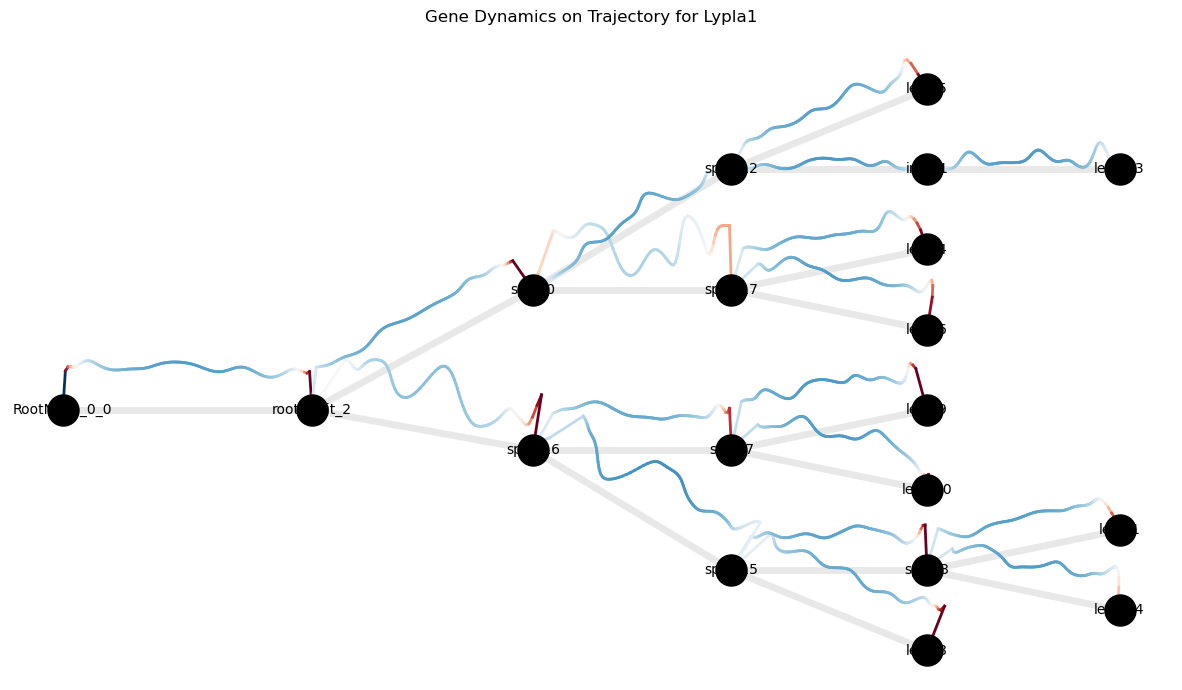

In [52]:
plot_gene_dynamics_on_trajectory(traj_graph, beta_assignments, adata, gene_name='Lypla1',
                                 resolution=100, curve_scale=100.0, blend_fraction=0.1,
                                 title="Gene Dynamics on Trajectory for Lypla1")